In [80]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os 
import lob_fe
import feature_selection
import read_data
from utils import train_val_split, generate_x_y
import warnings
import xgboost as xgb
import train

from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, precision_score, recall_score

import tensorflow as tf
import keras
from keras import backend as K
from keras.utils import np_utils
from keras.models import load_model, Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam 
from keras.layers.advanced_activations import LeakyReLU

warnings.filterwarnings("ignore")

In [116]:
# arguments
year = '2012'
month = '06'
day = '21'

nlevels = 10
label_horizons = [1, 2, 3, 5, 10, 50, 100]
# horizon limit = 2
tech_horizons = np.array([5,15])
feature_re_selection = False
tickers = [#'AAPL',
            # 'GOOG','INTC','MSFT'
           # ,'AMZN'
            ]
thres = 0.002

save_data = False
reload_data = False
feature_re_selection = False
train_model = False

# Data Preprocessing

In [117]:
# read_data and data preprocessing
if reload_data == True:
    for ticker in tickers:
        theMessageBook = read_data.read_messagebook_data(ticker, year, month, day)
        theOrderBook = read_data.read_orderbook_data(ticker, nlevels, year, month, day)
        df = theMessageBook.merge(theOrderBook, on=theMessageBook.index, how='left')

        # feature generation
        df = lob_fe.feature_generation(df, nlevels, tech_horizons)

        # label generation
        df, labels = lob_fe.generate_label(df, label_horizons, thres)

        try:
            full_data = pd.concat([full_data, df], axis=0)
        except:
            full_data = df

    del df

else:
    full_data = pd.read_parquet('full_data_for_cnn_lstm.parq', engine='pyarrow')


In [132]:
full_data.shape

(375635, 186)

## EDA

In [122]:
full_data['Price']

0         5861900
1         5861900
2         5861900
3         5860900
4         5863400
           ...   
375630    5778800
375631    5778800
375632    5778900
375633    5778900
375634    5780600
Name: Price, Length: 375635, dtype: int64

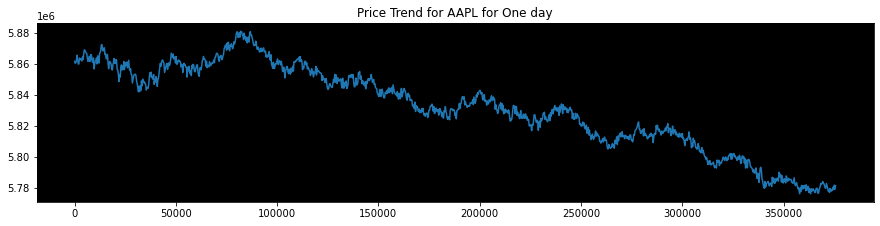

In [139]:
fig = plt.figure(facecolor = 'white', figsize = (15,5),)
ax0 = plt.subplot2grid((6,4), (1,0), rowspan=4, colspan=4)
ax0.plot(full_data.loc[::300,'Price'])
ax0.set_facecolor("black")
ax0.set_title("Price Trend for AAPL for One day")
plt.show()


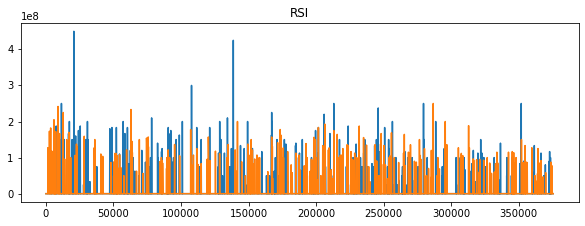

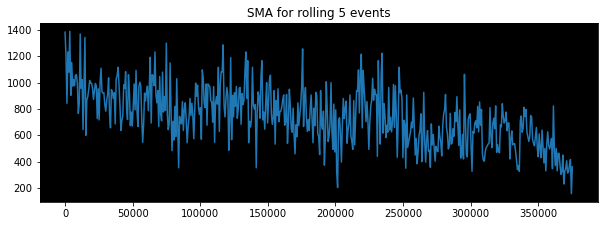

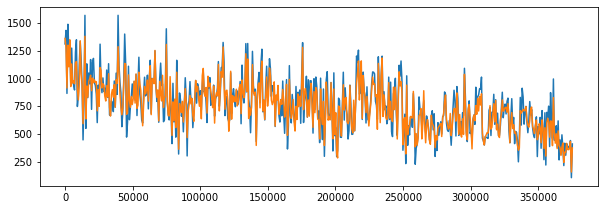

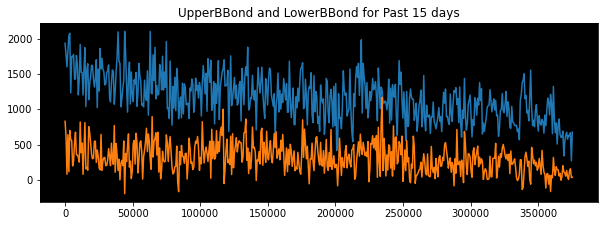

In [138]:
fig = plt.figure(facecolor = 'white', figsize = (10,5))
ax0 = plt.subplot2grid((6,4), (1,0), rowspan=4, colspan=4)
ax0.plot(full_data.loc[::70,['RSI_'+str(tech_horizons[0]), 'RSI_'+str(tech_horizons[1])]])
ax0.set_title("RSI")
plt.show()

fig = plt.figure(facecolor = 'white', figsize = (10,5))
ax1 = plt.subplot2grid((6,4), (1,0), rowspan=4, colspan=4)
ax1.set_facecolor("black")
ax1.plot(full_data.loc[::700,['SMA_'+str(tech_horizons[1])]])
ax1.set_title("SMA for rolling 5 events")
plt.show()

fig = plt.figure(facecolor = 'white', figsize = (10,5))
ax2 = plt.subplot2grid((6,4), (1,0), rowspan=4, colspan=4)
ax2.plot(full_data.loc[::700,['EWM_'+str(tech_horizons[0]), 'EWM_'+str(tech_horizons[1])]])
plt.show()

fig = plt.figure(facecolor = 'white', figsize = (10,5))
ax3 = plt.subplot2grid((6,4), (1,0), rowspan=4, colspan=4)
ax3.plot(full_data.loc[::700,['UpperBBond_15', 'LowerBBond_15']])
ax3.set_title('UpperBBond and LowerBBond for Past 15 days')
ax3.set_facecolor("black")
#fig.patch.set_facecolor('black')
plt.show()



In [90]:
if save_data == True:
    full_data.to_parquet('full_data_for_cnn_lstm.parq', engine='pyarrow')
    with open("labels.txt", "w") as output:
        for item in labels:
            output.write("%s\n" % item)

# Feature Selection

In [92]:
if feature_re_selection == True:
    full_data = pd.read_parquet('full_data_for_cnn_lstm.parq', engine='pyarrow')
    labels = open("labels.txt", "r").read().replace('\n', '.').split(".")[:-1]
    feature = feature_selection.feature_selection_ensemble(full_data, labels, tk=7)
    # feature.to_csv('ensemble_feature_selection_results.csv', index=False)
else:
    feature = pd.read_csv('ensemble_feature_selection_results.csv')

feature_final = np.array(feature.sort_values('total_arith_weight', ascending=False)[:40].index)

### Basline Comparison

In [ ]:
X_fs = full_data.loc[:,feature_final]
y = full_data.iloc[:, -3]

X_fs_normal = normalize(X_fs)
X_fs_train, X_fs_test, y_fs_train, y_fs_test = train_test_split(X_fs_normal, y, test_size=0.2, random_state=123)

xgb_fs = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xgb_fs.fit(X_fs_train, y_fs_train)
pred_fs = xgb_fs.predict(X_fs_test)


print(precision_score(y_fs_test, pred_fs, average='weighted'))
print(recall_score(y_fs_test, pred_fs, average='weighted'))

del  X_fs_train, X_fs_test, y_fs_train, y_fs_test 

# Model Structure

In [ ]:
# get arguments
tk = 7
k = 3
T = 100
save_fath = "./saved_model/saved_model.pb")

In [ ]:

if train_model == True:
    train.train(tk, k, T, full_data, feature_final, save_path)